# How to develop and run CUDA-Q programs on Amazon Braket

In this notebook, you will learn how you can use CUDA-Q and Amazon Braket together. First, we review how you can create a fully-featured CUDA-Q development environment on this Braket notebook instance. Then, we will use this environment to build and run CUDA-Q programs locally. Finally, you will execute CUDA-Q kernels remotely on Braket simulator and QPU backends. 

In [ ]:
import os

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

## Amazon Braket notebook instances as CUDA-Q development environments

We have already configured your Amazon Braket notebook instance for you to run CUDA-Q code, interactively. Let's review the steps to make this work.

Braket notebook instances are cloud-based quantum development environments fully managed by AWS. They come with the [Amazon Braket SDK](https://github.com/amazon-braket/amazon-braket-sdk-python) and [additional plugins and quantum development frameworks](https://github.com/amazon-braket) pre-installed.

Due to an incompatibility with an operating system library, [CUDA-Q](https://developer.nvidia.com/cuda-q) can't be installed natively at this point in time.

The solution we have deployed here (and we recently [published on the AWS Quantum Blog channel](https://aws.amazon.com/blogs/quantum-computing/how-to-run-cuda-q-programs-on-amazon-braket-notebook-instances/)) uses a Jupyter kernel running a CUDA-Q Docker container. To run the CUDA-Q code below, make sure you have selected the kernel `docker_cudaq` on the top-right of this notebook.

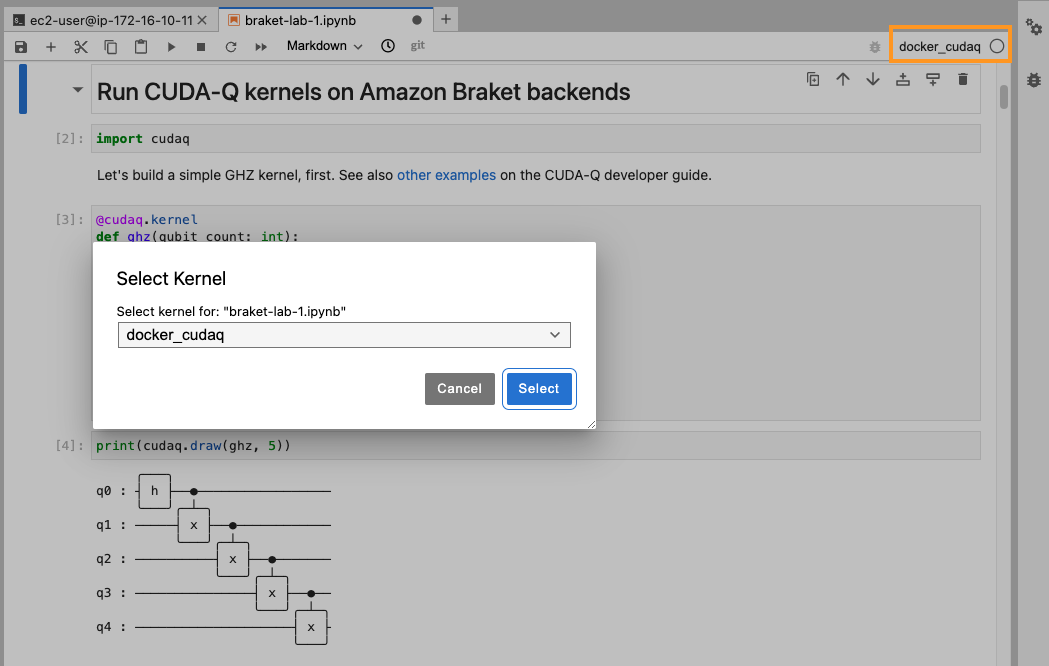

### Solution overview

Let's review the solution and verify the required components are in place. Actually, there are only two compontents which can be configured with just a few lines of code.

#### Component 1: Docker image

The first component needed is a Dockerfile providing a CUDA-Q installation as well as additional Python modules for the Jupyter kernel (i.e. [ipython](https://pypi.org/project/ipython/) and [ipykernel](https://pypi.org/project/ipykernel/)) and for the code we want to run below (in our case [amazon-braket-sdk](https://pypi.org/project/amazon-braket-sdk/)).

```dockerfile
FROM nvcr.io/nvidia/quantum/cuda-quantum:cu12-0.9.1

RUN pip install --upgrade pip ipython ipykernel amazon-braket-sdk

ENTRYPOINT []
```

You don't have to build a Docker image here. We have done this already for you. To verify it's available, you may open a terminal (for example with `File > New > Terminal`), enter the command

```shell
docker images
```

and make sure the output contains an image named `cudaq-jupyter-kernel`

```shell
REPOSITORY             TAG       IMAGE ID       CREATED       SIZE
cudaq-jupyter-kernel   latest    083e9147de15   7 hours ago   7.04GB
```

#### Component 2: Jupyter kernel definition

The second component is the Jupyter kernel definition that allows you to select the kernel as described above. For that, a directory `/home/ec2-user/.local/share/jupyter/kernels/docker_cudaq/` has to exist and contain a file `/home/ec2-user/.local/share/jupyter/kernels/docker_cudaq/kernel.json` with the content

```json
{
 "argv": [
  "/usr/bin/docker",
  "run",
  "--network=host",
  "-v",
  "{connection_file}:/connection-spec",
  "--mount",
  "type=bind,source=/home/ec2-user/braket_workshops,target=/home/cudaq/Braket_workshops",
  "--mount",
  "type=bind,source=/home/ec2-user/amazon-braket-examples/examples,target=/home/cudaq/Braket_examples",
  "cudaq-jupyter-kernel",
  "python",
  "-m",
  "ipykernel_launcher",
  "-f",
  "/connection-spec"
 ],
 "display_name": "docker_cudaq",
 "language": "python"
}
```

You may verify this on your notebook instance by running in your terminal the command

```shell
cat /home/ec2-user/.local/share/jupyter/kernels/docker_cudaq/kernel.json
```

Finally, you can also verify that the Jupyter kernel is available by running the command

```shell
jupyter kernelspec list
```

and making sure the output contains

```shell
Available kernels:
  conda_braket     /home/ec2-user/.local/share/jupyter/kernels/conda_braket
  docker_cudaq     /home/ec2-user/.local/share/jupyter/kernels/docker_cudaq
```

With these two components, you can now develop and execute interactively CUDA-Q code in this notebook.

## Run CUDA-Q kernels on Amazon Braket

In [ ]:
import cudaq

Let's build a simple GHZ kernel, first. See also [other examples](https://nvidia.github.io/cuda-quantum/latest/using/examples/building_kernels.html) on the CUDA-Q developer guide.

In [ ]:
@cudaq.kernel
def ghz(qubit_count: int):
    # Allocate our qubits.
    qvector = cudaq.qvector(qubit_count)
    # Place the first qubit in the superposition state.
    h(qvector[0])
    # Loop through the allocated qubits and apply controlled-X,
    # or CNOT, operations between them.
    for qubit in range(qubit_count - 1):
        x.ctrl(qvector[qubit], qvector[qubit + 1])
    # Measure all qubits in the Z-basis
    mz(qvector)


print(cudaq.draw(ghz, 5))

### Run on a local CUDA-Q circuit simulation backend

CUDA-Q comes with a selection of CPU and GPU-backed local [circuit simulation backends](https://nvidia.github.io/cuda-quantum/latest/using/backends/simulators.html).

In [ ]:
print(f"NVIDIA GPUs available on instance: {cudaq.num_available_gpus()}")

We don't have an NVIDIA GPU available on this notebook instance, but we can work with the `qpp-cpu` backend which provides a state vector simulator using the CPU of our instance.

In [ ]:
cudaq.set_target('qpp-cpu')

<div class="alert alert-block alert-info"> 
    <b>Note:</b> When you create a Braket notebook instance, you can choose from a selection of instance types comprising varying combinations of compute capacity and memory (see the screenshot below). The following table provides an overview of the GPU-accelerated instance types. On these instances you also have access to the CUDA-Q GPU-based simulators.
</div>

| Instance Type  | vCPUs | Instance Memory (GiB) | GPU Model   | GPUs | Total GPU Memory (GB) | Network Bandwidth (Gbps) | GPU Peer to Peer |
| -------------- | ----- | --------------------- | ----------- | ---- | --------------------- | ------------------------ | ---------------- |
| ml.p3.2xlarge  | 8     | 61                    | NVIDIA V100 | 1    | 16                    | up to 10                 | N/A              |
| ml.p3.8xlarge  | 32    | 244                   | NVIDIA V100 | 4    | 64                    | 10                       | NVLink           |
| ml.p3.16xlarge | 64    | 488                   | NVIDIA V100 | 8    | 128                   | 25                       | NVLink           |

Source: [Amazon SageMaker pricing page](https://aws.amazon.com/sagemaker-ai/pricing/)

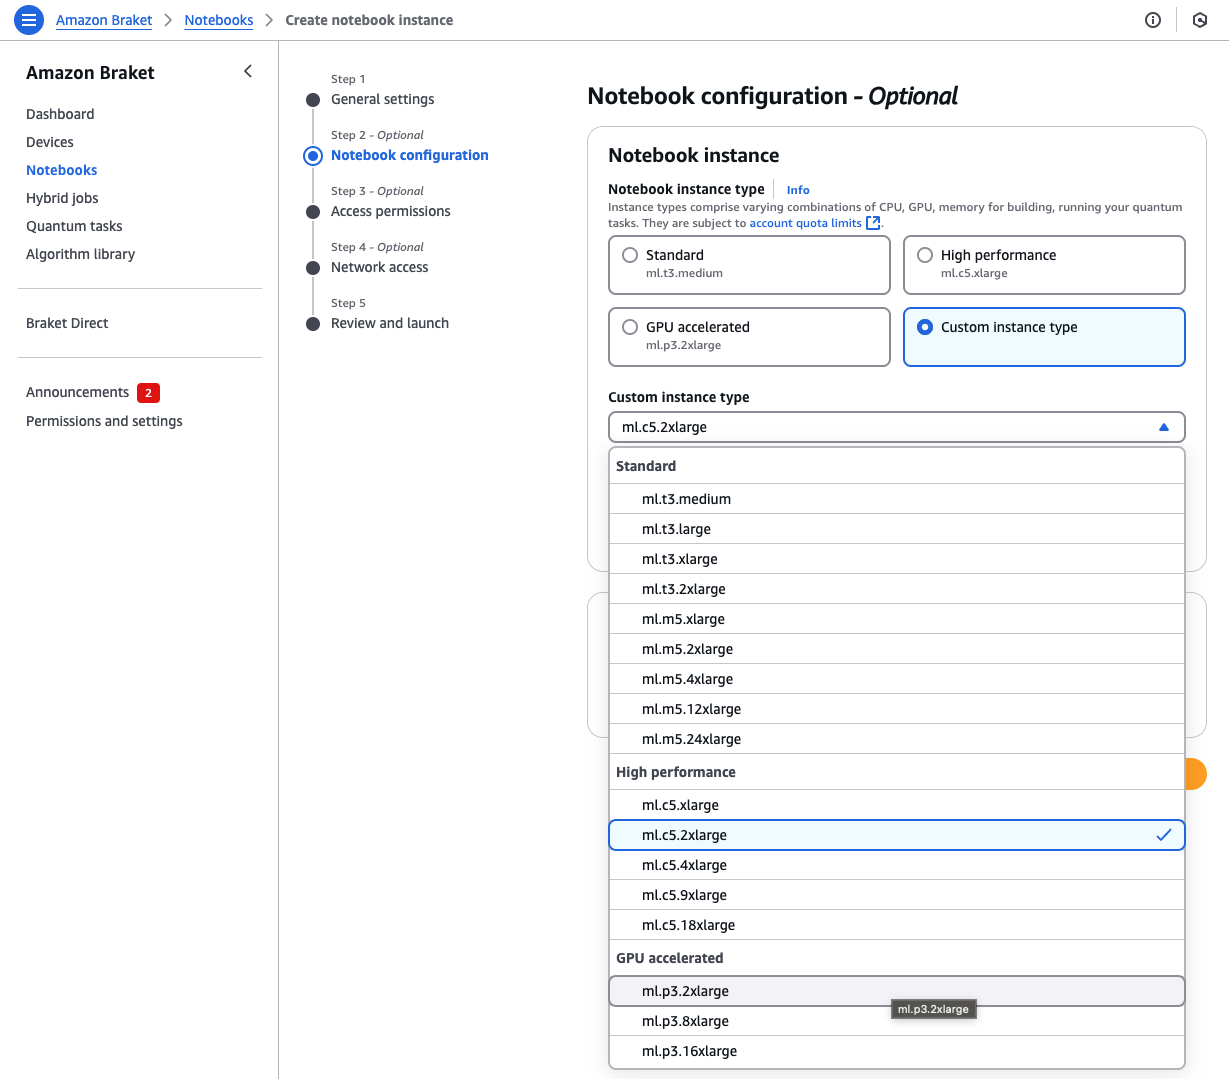

Let's sample several shots of a Z-basis measurement of our GHZ circuit.

In [ ]:
result = cudaq.sample(ghz, 5, shots_count=1000)

print(f"Measurement samples: {result}")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

counts = dict(sorted(result.items()))
plt.figure(figsize=(4, 3))
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.tight_layout()
plt.show()

### Run on a remote Braket backend

Now, let's have a look how we can run on devices made available by Amazon Braket. This notebook instance has programmatic access to Braket pre-configured and we can query the Braket service to find out which devices are online. For this we use the the [`AwsDevice`](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html#braket.aws.aws_device.AwsDevice.get_devices) module of the [Amazon Braket Python SDK](https://amazon-braket-sdk-python.readthedocs.io/en/stable/index.html).

For more information on how to get started with Braket and set up your own local development environment for programmatic access, see [this blog post](https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/). Also, see the [Braket section](https://nvidia.github.io/cuda-quantum/latest/using/backends/cloud/braket.html) in the CUDA-Q developer guide for more information on how to use CUDA-Q with Braket.

In [ ]:
from braket.aws import AwsDevice

AwsDevice.get_devices(statuses=["ONLINE"])

Alternatively, you can follow the link to the [device page](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices) in the Braket management console.

<div class="alert alert-block alert-info"> 
    <b>Note:</b> The Amazon Braket <b>service</b> is currently available in 5 different <a href="https://aws.amazon.com/about-aws/global-infrastructure/regions_az">AWS Regions</a>. A Braket <b>device</b> is local to a single region. Each QPU only exisits in one region. On-demand simulators are deployed in several regions. You can find the region of a device in its Amazon Resource Name (ARN) (e.g. in the output of the code cell above) and on the device page in the Braket management console. You may also check the developer guide for more information about <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html">Braket supported regions and devices</a>.
</div>

Let's run on the Braket on-demand statevector simulator SV1 by setting the CUDA-Q target and execute the kernel again.

In [ ]:
from braket.devices import Devices

cudaq.set_target("braket", machine=Devices.Amazon.SV1)

result = cudaq.sample(ghz, 5, shots_count=1000)

print(f"Measurement samples: {result}")

You may have noted that the above cell took a few seconds to complete. This is because `cudaq.sample` interacted with a Braket API to create a **quantum task** in the AWS cloud and waited for it to complete. Communciation with the service and interaction with a remote device added some latency. Also, Braket quantum tasks follow a certain lifecyle which comes with an overhead compared to working locally where the state is not preserved. But, this also has a benefit: task information, metadata and results are stored reliably on AWS and can be retrieved later. Also, for larger circuits taking longer to be simulated, this overhead can be neglected.

You will be able to find your task on the [quantum tasks page](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/tasks) of the Braket management console.

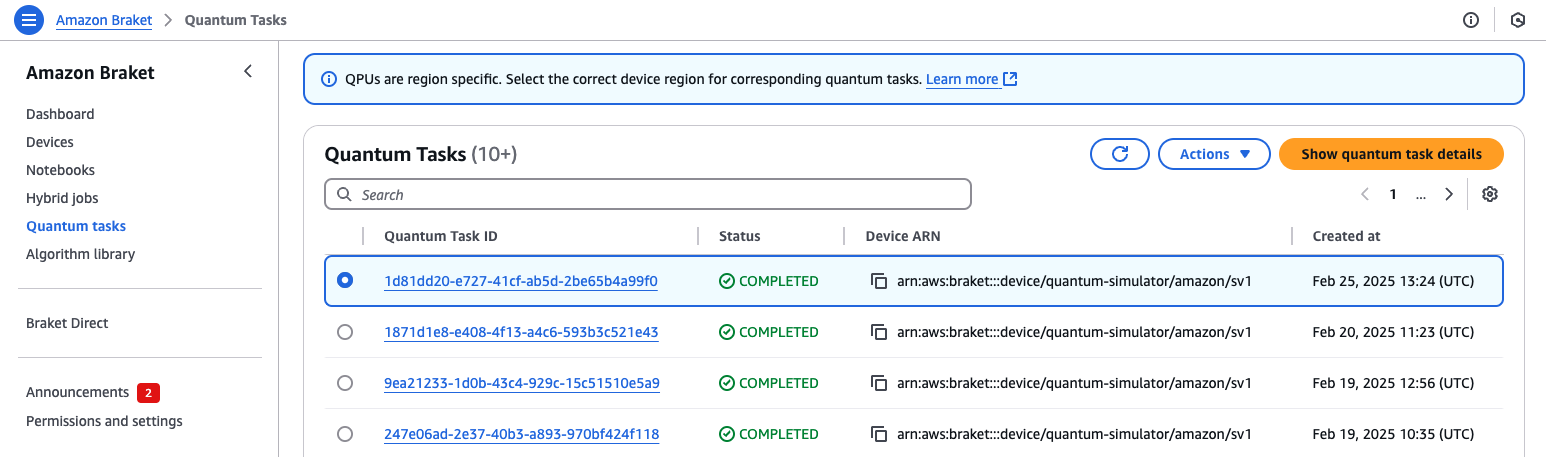

Click on the task to find more information. In particular, you find the **quantum task ARN** and the location in [Amazon S3](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html) where the task results are stored, durably. You may recall the acronym **ARN**  for Amazon Resource Name, we came across earlier. Every AWS resource in the cloud can be uniquely and unambiguously identified with its ARN.

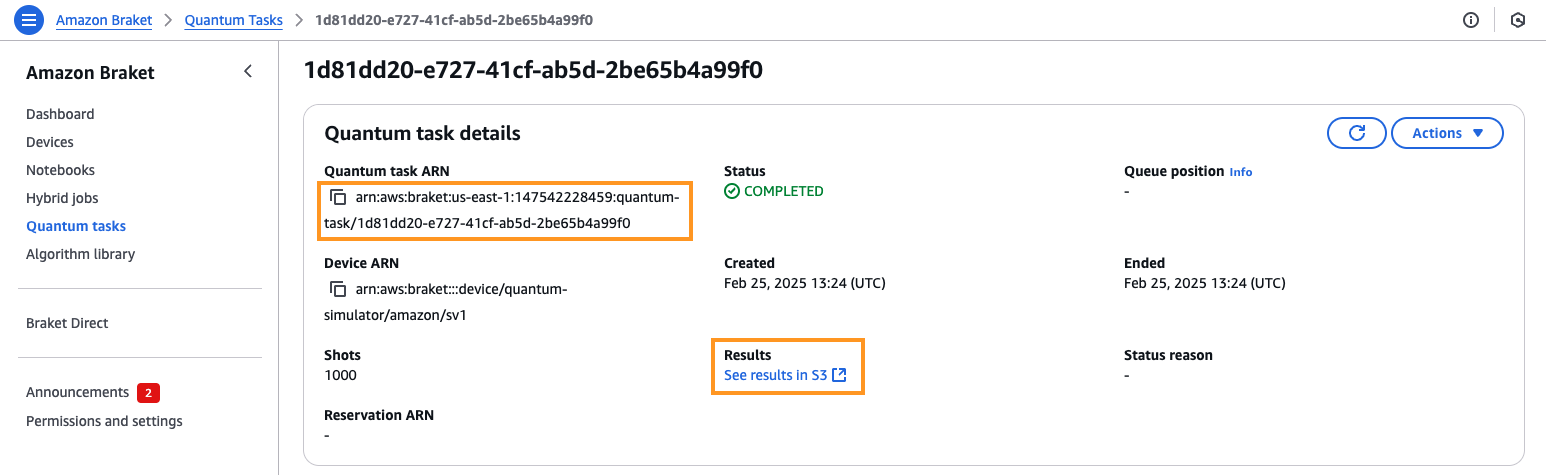

Next, we show you how you can retrieve task results and metadata programmatically at a later point in time, for instance when you have restarted your notebook.

<div class="alert alert-block alert-info"> 
    <b>Your task:</b> Copy the ARN of your AWS quantum task and paste it in the next cell. 
</div>

In [ ]:
from braket.aws import AwsQuantumTask

task_arn = "<REPLACE_WITH_YOUR_TASK_ARN>"
sv1_task = AwsQuantumTask(task_arn)

print(f"The state of your task is {sv1_task.state()}\n")
print(f"You may go ahead and inspect the task result object:\n\n {sv1_task.result()}")

Note that `AwsQuantumTask.result()` will download a local copy of the result stored on Amazon S3.

In the task result object, you find the aggregated `measurement_counts` that have been returned by `cudaq.sample` above. 

In [ ]:
sv1_result = sv1_task.result()

print(sv1_result.measurement_counts)

In addition, you can inspect the `measurements` array containing the Z-basis measurements of each invidiual qubit in each shot:

In [ ]:
print(sv1_result.measurements)

It may also be interesting to inspect QASM string which has been generated by the `nvq++` compiler:

In [ ]:
print(sv1_result.additional_metadata.action.source)

Finally, you can also check the actual execution duration of the simulation on SV1:

In [ ]:
print(f"Execution duration on SV1: {sv1_result.additional_metadata.simulatorMetadata.executionDuration} ms")

### Run on quantum hardware available on Braket

Let's move forward and run on real quantum hardware. For this tutorial, let's select the [Rigetti Ankaa-3](https://qcs.rigetti.com/qpus) QPU.

<div class="alert alert-block alert-info"> 
    <b>Note:</b> QPUs are not elastic compute resources, yet. Since all of us are about to run on the same QPU, our quantum tasks may take a while to complete. After creation, the task will be queued before it will eventually be processed on the available QPU. Queued tasks are processed first in, first out. You can check the length of the device queue in the management console and programmatically.
</div>

In [ ]:
from braket.devices import Devices

qpu = AwsDevice(Devices.Rigetti.Ankaa3)
qpu.queue_depth()

To continue with this notebook while our QPU task is queued, we use CUDA-Q's [asynchronyous kernel execution](https://nvidia.github.io/cuda-quantum/latest/examples/python/executing_kernels.html#Parallelization-Techniques):

In [ ]:
cudaq.set_target("braket", machine=Devices.Rigetti.Ankaa3)

result = cudaq.sample_async(ghz, 5, shots_count=1000)

While you wait for your task to complete, look it up on the [quantum tasks page](https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/tasks) of the Braket management console.

<div class="alert alert-block alert-info"> 
    <b>Note:</b> The above link directs you to the device page in a different AWS region as the device page where you looked up your SV1 tasks. Remember that while Amazon Braket is available in different [AWS regions](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html), QPUs are only available in a single region. The quantum tasks are placed in the region of the QPU.
</div>

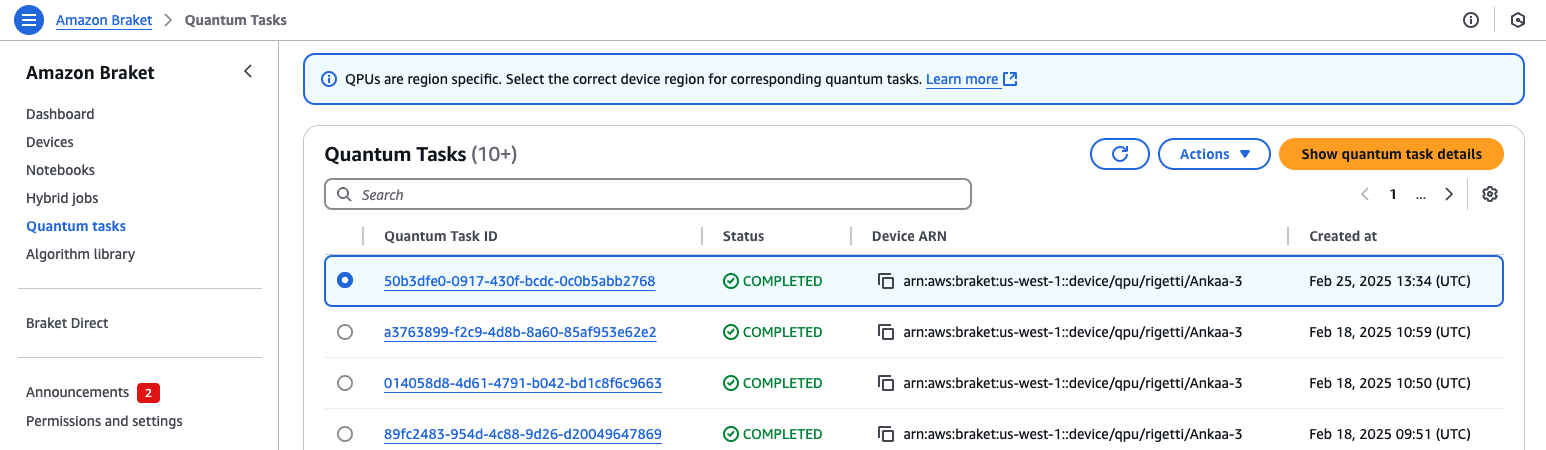

<div class="alert alert-block alert-info"> 
    <b>Your task:</b> Find and copy the ARN of your quantum task on Ankaa-3 and paste it in the next cell. 
</div>

In [ ]:
task_arn = "<REPLACE_WITH_YOUR_TASK_ARN>"

qpu_task = AwsQuantumTask(task_arn)

print(f"The state of your task is {qpu_task.state()}\n")

For a task in QUEUED state, we can query its position in the queue:

In [ ]:
qpu_task.queue_position()

Once completed, we can retrieve the task results:

In [ ]:
qpu_task_state = qpu_task.state()
if qpu_task_state == "COMPLETED":
    qpu_result = qpu_task.result()

    counts = dict(sorted(qpu_result.measurement_counts.items()))
    print(counts)
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print(f"Your task is in state {qpu_task_state}")

As we see below, program we have sent to Braket did not change compared to our previous run on SV1.

In [ ]:
print(qpu_result.additional_metadata.action.source)

But the circuit actually executed on the device is different. When you run a circuit on a QPU, behind the scenes, Amazon Braket will do a series of compilation steps to optimize your circuit and map the abstract circuit to the physical qubits and the native gates of the QPU.

We can check the list of native gates and the connectivity graph of our QPU programmatically or on the [device page](https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/devices/arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3) in the console.

In [ ]:
print(f'{qpu.name} native gates: {qpu.properties.paradigm.nativeGateSet}\n')
print(f"The connectivity graph of the qubits for this device:\n {qpu.properties.paradigm.connectivity}\n")

Below, we can inspect the compiled circuit executed on the Rigetti QPU:

In [ ]:
print(qpu_result.get_compiled_circuit())

<div class="alert alert-block alert-info"> 
    <b>Congratulations</b>, you have executed a CUDA-Q kernel on real quantum hardware available on Amazon Braket. 
</div>

## Where to go from here?

We have seen above the result of running our CUDA-Q GHZ kernel on noisy quantum hardware. An interesting next step could be to investigate the device calibration data (you can do that on the device page in the management console or programmatically with `AwsDevice.properties.standardized`), and try to build a noise model from it. Check out [this example notebook](/home/ec2-user/amazon-braket-examples/examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb) to learn how you can map device calibration data to noise channels in a noise model. You could then try to implement a [CUDA-Q noise model](https://nvidia.github.io/cuda-quantum/latest/examples/python/noisy_simulations.html) for the Rigetti QPU and simulate your GHZ kernel with device noise to compare the results with the ones from the actual QPU.

We will now move on to something else and explore how you can run an entire algorithm written with CUDA-Q on [Amazon Braket Hybrid Jobs](https://docs.aws.amazon.com/braket/latest/developerguide/braket-what-is-hybrid-job.html), providing a fully-managed compute environment for the execution of hybrid quantum-classical workloads.